# Manipulating VTK files with Paraview
This IPython notebook investigates the loading and manipulating of VTK files through use of the Paraview Python libraries.

## Loading Paraview libraries
Paraview provides a Python shell **pvpython** which is setup with the necessary include paths to enable the use of the libraries. Through investigation of load orders and module load paths, the below was determined as the required approach to utilise the Paraview libraries in IPython.

In [1]:
import sys
paraview_path = 'c:/program files (x86)/Paraview 4.3.1'
paraview_version = 'paraview-4.3'
#paraview_path = 'c:/program files/Paraview 4.4.0'
sys.path = ["%s/lib/%s/site-packages/"%(paraview_path,paraview_version),
            "%s/lib/%s/site-packages/vtk"%(paraview_path,paraview_version)
           ] + sys.path
import os
os.environ['PATH'] = "%s/bin;"%paraview_path + os.environ['PATH']
import paraview.simple

paraview version 4.3.1


## Loading VTK files
The provided VTK files were presented as a set of partial meshes, the filenames were not intuitively related to their contents. Paraview GUI was used to interactively examine the files to find some suitable for beginning basic visualisation and manipulation investigations. By aggregating all files with name matching 'large_turbine_solar_refined\_0\_*' a complete data set was discovered.

Open up all the discovered data files into an array of VTK data objects

In [2]:
import glob
dataFiles = glob.glob( 
    'C:/Users/rd73/Documents/Work/SWEPT2/samples/CFD/large_turbine_solar_refined_P6_OUTPUT/large_turbine_solar_refined_0_*')

vtkData = []
for d in dataFiles:
    vtkData.append( paraview.simple.OpenDataFile( d ))

Join the datasets together so as to merge them into one.

In [3]:
vtkData = paraview.simple.AppendDatasets( *vtkData )

## Slicing the object
In order to compare planar LIDAR data with 3-d CFD output, a slice plane is required to extract the same data. Extract a horizontal slice by setting the normal vector of the plane to the Y-axis.

In [4]:
slicer = paraview.simple.Slice()
slicer.Input = vtkData
slicer.Crinkleslice = True
slicer.SliceType.Origin = [0,0,0]
slicer.SliceType.Normal = [0,1,0]
slicer.UpdatePipeline()
cells = slicer.CellData
points = slicer.PointData

In [5]:
cd = paraview.simple.CellDatatoPointData( slicer, PassCellData=1)

## Export of data from the slice
Data from the slice needs to be exported into a format usable in other tools. CSV is a reasonable choice:

In [6]:
#paraview.simple.Show(vtkData)
writer = paraview.simple.CreateWriter('turbine-out.csv',cd)
writer.FieldAssociation = "Points"
writer.UpdatePipeline()
with open('turbine-out.csv','r') as fh:
    l = 0
    while l < 10:
        print fh.readline(),
        l += 1

"T","V:0","V:1","V:2","p","rho","Points:0","Points:1","Points:2"
288.15,0.66428,0,-3.5681e-022,1.0133e+005,1.2252,0,0,1.5
288.15,0.66428,0,-7.1363e-022,1.0133e+005,1.2252,0,0,1.75
288.15,0.66428,0,-7.1363e-022,1.0133e+005,1.2252,0,0.01,1.75
288.15,0.66428,0,-3.5681e-022,1.0133e+005,1.2252,6.9389e-018,0.01,1.5
288.15,0.66428,0,7.731e-022,1.0133e+005,1.2252,0,0,-1.75
288.15,0.66428,0,3.8655e-022,1.0133e+005,1.2252,0,0,-1.5
288.15,0.66428,0,3.8655e-022,1.0133e+005,1.2252,6.9389e-018,0.01,-1.5
288.15,0.66428,0,7.731e-022,1.0133e+005,1.2252,0,0.01,-1.75
288.15,0.66428,0,0,1.0133e+005,1.2252,0,0,1.25


In [7]:
paraview.simple.Disconnect()

## Replicating the wake diagram produced from LIDAR data
Now to try to perform similar analysis on the data as was done with the LIDAR data. This will follow a number of steps:
  1. Cut the data down to a box similar to the LIDAR data extent.
  1. Sample points in the same pattern as done with the LIDAR scan i.e. matching range gates and azimuths.
  1. Perform bilinear interpolation to fill the grid.
  1. Extract wake properties such as wind speed deficit.

In [8]:
import pandas
import numpy

df = pandas.read_csv('turbine-out.csv')

df.rename( columns = { 'Points:0':'X','Points:1':'Y','Points:2':'Z'},inplace=True)

df.describe()

,T,V:0,V:1,V:2,p,rho,X,Y,Z
count,90938.000000,90938.000000,90938.000000,90938.000000,90938.000000,9.093800e+04,90938.000000,90938.000,90938.000000
mean,288.159689,0.634566,-0.000467,-0.002323,101329.961072,1.225200e+00,15.285347,0.005,0.003944
std,0.001736,0.065674,0.000495,0.012420,0.622708,7.045514e-13,2.995128,0.005,0.588093
min,288.150000,0.444060,-0.006501,-0.081053,101320.000000,1.225200e+00,0.000000,0.000,-1.750000
25%,288.160000,0.613930,-0.000565,-0.005612,101330.000000,1.225200e+00,13.061000,0.000,-0.320900
50%,288.160000,0.656000,-0.000509,-0.001460,101330.000000,1.225200e+00,15.416000,0.005,0.002597
75%,288.160000,0.666030,-0.000305,0.000531,101330.000000,1.225200e+00,17.743000,0.010,0.327540
max,288.160000,0.854180,0.000474,0.082352,101330.000000,1.225200e+00,20.000000,0.010,1.750000


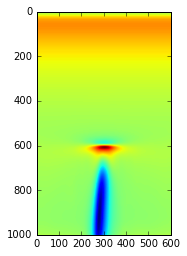

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

points = df.as_matrix(columns=['Z','X'])
values = df['V:0']

grid_x,grid_z = numpy.mgrid[0:20:1000j,-1.75:1.75:600j]

gridded = griddata( points,values,(grid_z,grid_x),method='linear')

plt.imshow(gridded)

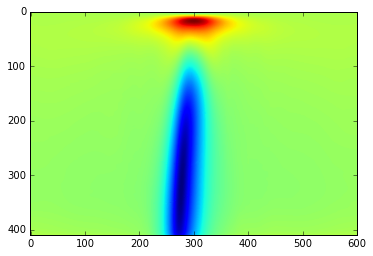

In [10]:
sub_im = gridded[ 590:1000,0:600]
plt.imshow(sub_im)

## Sampling points from the slice of VTK data
Now that we have an image of a similar area to that obtained from the LIDAR data, try to prepare a similar set of data. Set up an array of sample points that approximate the positions of data points returned by the LIDAR system.

In [11]:
ranges = [ x*30+45 for x in range(16)]

angles = numpy.linspace( 150, 210, 21 )

rad_angles = angles * numpy.pi / 180

sample_points = zip( rad_angles.repeat( len(ranges)), ranges*len(rad_angles))
sample_df = pandas.DataFrame( sample_points )

sample_df.columns = ['radians','ranges']

sample_df['x'] = sample_df['ranges'] * numpy.sin( sample_df['radians'])
sample_df['y'] = sample_df['ranges'] * numpy.cos( sample_df['radians'])

Scale and transpose the coordinates to put them within the range of the imagery we have.

In [12]:
sample_df['scaled_x'] = sample_df['x'] + 300
sample_df['scaled_y'] = abs(sample_df['y']) * 410/500

Now redo the interpolation but only onto the coordinates we have calculated. Use the nearest point to avoid changing data values further:

In [13]:
point_data = sub_im.flatten(order='C')

points_coords = []
for y in range(410):
    for x in range(600):
        points_coords.append((x,y))

interp_points = griddata( points_coords, point_data, ( sample_df['scaled_x'], sample_df['scaled_y']), method='nearest')

And then interpolate onto an image for display:

In [14]:
sample_df['interp_points'] = interp_points

grid_x,grid_y = numpy.mgrid[-300:300:600j,0:-500:-500j]
new_grid = griddata( sample_df[['x','y']],sample_df['interp_points'],(grid_x,grid_y),method='linear')

Image must be rotated clockwise 90 degrees to match with LIDAR.

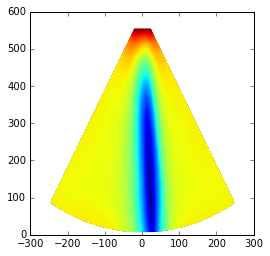

In [15]:
new_grid_rot = numpy.rot90(new_grid,k=3)

plt.imshow(new_grid_rot,extent=(-300,300,0,600))